In [1]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
import math
import random

random.seed(10)
np.random.seed(10)

# Load the Excel spreadsheet into a pandas DataFrame
df = pd.read_excel('C:/Users/sayan/Downloads/EVCS/Data/Howard_Baltimore/BaltimoreMSA/TAZODNew2.xlsx')

# Calculate distance for each row and store it in a new column
distances = []
for index, row in df.iterrows():
    origin = (row['Origin_Lat'], row['Origin_Lon'])
    destination = (row['Destination_Lat'], row['Destination_Lon'])
    distance = geodesic(origin, destination).miles
    distance = round(distance, 1)  # Round distance to one decimal place
    distances.append(distance)

df['Distance (miles)'] = distances

# Drop rows with Distance (miles) equal to 0
df = df[df['Distance (miles)'] != 0]

# Categorize the trips based on trip length
df['Trip Category'] = pd.cut(df['Distance (miles)'], bins=[0, 15, 30, float('inf')], labels=['HBW', 'HBNW', 'HBO'])

# Count the number of trips in each category
trip_counts = df[['Trip Category', 'Trips']].groupby('Trip Category').sum()

# Define dictionaries for mean speeds and standard deviations
mean_speeds = {'HBW': 30.2, 'HBNW': 38, 'HBO': 50.4}
std_devs = {'HBW': 4, 'HBNW': 5.08, 'HBO': 6.78}

# Function to generate random speeds based on normal distribution
def generate_random_speed(row):
    category = row['Trip Category']
    mean = mean_speeds[category]
    std = std_devs[category]
    return np.random.normal(mean, std)

# Generate random speeds based on normal distribution
df['Random Speed'] = df.apply(generate_random_speed, axis=1)

# Calculate travel time in minutes for each trip using the random speeds
df['Travel Time (minutes)'] = df['Distance (miles)'] / df['Random Speed'] * 60

# Group the DataFrame by 'Trip Category' and calculate the mean and standard deviation of travel time for each group
mean_travel_time = df.groupby('Trip Category')['Travel Time (minutes)'].mean()
std_travel_time = df.groupby('Trip Category')['Travel Time (minutes)'].std()

# Save the mean and standard deviation of travel time for each trip category to separate variables
mean_hbw = round(mean_travel_time['HBW'], 1)
std_hbw = round(std_travel_time['HBW'], 1)
mean_hbnw = round(mean_travel_time['HBNW'], 1)
std_hbnw = round(std_travel_time['HBNW'], 1)
mean_hbo = round(mean_travel_time['HBO'], 1)
std_hbo = round(std_travel_time['HBO'], 1)

# Calculate the percentage of different trips
p_hbw = trip_counts.iloc[0, 0] / trip_counts.sum()
p_hbnw = trip_counts.iloc[1, 0] / trip_counts.sum()
p_hbo = trip_counts.iloc[2, 0] / trip_counts.sum()

# Group the DataFrame by unique 'Origin_Lat' and 'Origin_Lon' and calculate the mean of 'HHs20' for each group
grouped_df = df.groupby(['Origin_Lat', 'Origin_Lon'])['HHs20'].mean().reset_index()

# Calculate the total number of unique households by summing 'HHs20'
total_households = grouped_df['HHs20'].sum()

# Create a list of percentage distributions for households with different numbers of cars
percentage_distribution = [0.10057, 0.346925, 0.357646, 0.19486]

# Calculate the number of cars for each household based on the percentage distribution
num_cars_distribution = np.random.choice(range(4), int(total_households), p=percentage_distribution)

# Sum the total number of cars
total_cars = sum(num_cars_distribution)

# Calculate total_ev as a percentage of the number of cars
total_ev = math.ceil((total_cars * 0.1))  # Assuming 10% of cars are EVs

print("Total Number of Cars:", total_cars)
print("Total Number of EVs:", total_ev)




Total Number of Cars: 2192801
Total Number of EVs: 219281


In [2]:
# ---------Trips, Departures, and Arrivals
# Step 1: Probability of HBNW and HBO trips after completion of HBW trips
hbnw_prob = p_hbnw.item() / p_hbw.item()
hbo_prob = p_hbo.item() / p_hbw.item()

# Step 2: Distance traveled for all three trip categories
hbw_distances = df[df['Trip Category'] == 'HBW']['Distance (miles)']
hbnw_distances = df[df['Trip Category'] == 'HBNW']['Distance (miles)']
hbo_distances = df[df['Trip Category'] == 'HBO']['Distance (miles)']

# Step 3: EV utilization and SoC after each trip
initial_soc = 1  # Initial state of charge (SoC)
T = 24 * 60  # Total minutes in a day

# Define charging powers and range added per hour for different charger levels (in kW and miles/hour)
level1_power_range = (1.3, 2.4)  # Level 1 charger power range (kW)
level1_range_added_per_hour = (3, 5)  # Range added per hour for Level 1 charger (miles/hour)

level2_power_range = (3, 19)  # Level 2 charger power range (kW)
level2_range_added_per_hour = (18, 28)  # Range added per hour for Level 2 charger (miles/hour)

level3_power = (150, 200)  # Level 3 charger power (kW)
level3_range_added_per_hour = (100, 200)  # Range added per hour for Level 3 charger (miles/hour)

# Function to estimate departure, arrival, and travel time for an individual EV
def estimate_departure_arrival_travel_time_with_trip_count(congestion_factor=1.07):
    departure_times = []
    arrival_times = []
    travel_times = []
    current_time = 0  # Start at the beginning of the day
    
    # Function to generate trip times for a given category
    def generate_trip_times(mean, std):
        travel_time = np.random.normal(mean, std)
        departure_time = np.random.randint(current_time, T)
        arrival_time = (departure_time + travel_time) % T
        return departure_time, arrival_time, travel_time

    # First HBW trip
    dep, arr, trav = generate_trip_times(mean_hbw, std_hbw)
    departure_times.append(dep)
    arrival_times.append(arr)
    travel_times.append(trav)
    current_time = arr  # Update current time to arrival time of the first trip

    # Probability for additional HBNW and HBO trips
    prob = np.random.random()
    if prob < hbnw_prob:
        dep, arr, trav = generate_trip_times(mean_hbnw, std_hbnw)
        departure_times.append(dep)
        arrival_times.append(arr)
        travel_times.append(trav)
        current_time = arr
    
    if prob < hbo_prob:
        dep, arr, trav = generate_trip_times(mean_hbo, std_hbo)
        departure_times.append(dep)
        arrival_times.append(arr)
        travel_times.append(trav)
        current_time = arr

    # Apply congestion factor to travel times between 8-9 AM and 5-6 PM
    for i in range(len(departure_times)):
        if (8*60) <= departure_times[i] < (9*60) or (17*60) <= departure_times[i] < (18*60):
            travel_times[i] *= congestion_factor

    return departure_times, arrival_times, travel_times

# Total number of trips in the dataset
total_trips = df['Trips'].sum()  

# Number of EV trips (10% of the total trips)
num_ev_trips = int(total_trips * 0.1)

# Monte Carlo simulation for EV trips
results_home_charge = []
results_away_charge = []
for _ in range(num_ev_trips):  # Limit the number of simulations to the number of EV trips
    dep_times, arr_times, trav_times = estimate_departure_arrival_travel_time_with_trip_count()
    results_home_charge.append((dep_times, arr_times, trav_times))
    results_away_charge.append((dep_times, arr_times, trav_times))

# Print results for verification
print(f"Simulated {num_ev_trips} EV trips out of {total_trips} total trips.")
print("Home Charging Results:", results_home_charge[:5])  # Print first 5 results for brevity
print("Away Charging Results:", results_away_charge[:5])  # Print first 5 results for brevity




Simulated 1623872 EV trips out of 16238720 total trips.
Home Charging Results: [([32], [29.989622681673556], [-2.0103773183264444]), ([166], [174.71971913501068], [8.719719135010687]), ([35], [59.7699175825002], [24.769917582500195]), ([153], [159.4642744758398], [6.464274475839803]), ([1199], [1204.6105434639321], [5.610543463932167])]
Away Charging Results: [([32], [29.989622681673556], [-2.0103773183264444]), ([166], [174.71971913501068], [8.719719135010687]), ([35], [59.7699175825002], [24.769917582500195]), ([153], [159.4642744758398], [6.464274475839803]), ([1199], [1204.6105434639321], [5.610543463932167])]


Total Number of Households with EVs: 108555
For Home Charger Percentage: 0%
Total Number of Public Charging Stations: 25345
Total Number of Home Charging Stations: 0

For Home Charger Percentage: 50.0%
Total Number of Public Charging Stations: 13124
Total Number of Home Charging Stations: 54864

For Home Charger Percentage: 60.0%
Total Number of Public Charging Stations: 10580
Total Number of Home Charging Stations: 65837

For Home Charger Percentage: 70.0%
Total Number of Public Charging Stations: 7996
Total Number of Home Charging Stations: 76809

For Home Charger Percentage: 80.0%
Total Number of Public Charging Stations: 5379
Total Number of Home Charging Stations: 87782

For Home Charger Percentage: 90.0%
Total Number of Public Charging Stations: 2726
Total Number of Home Charging Stations: 98755



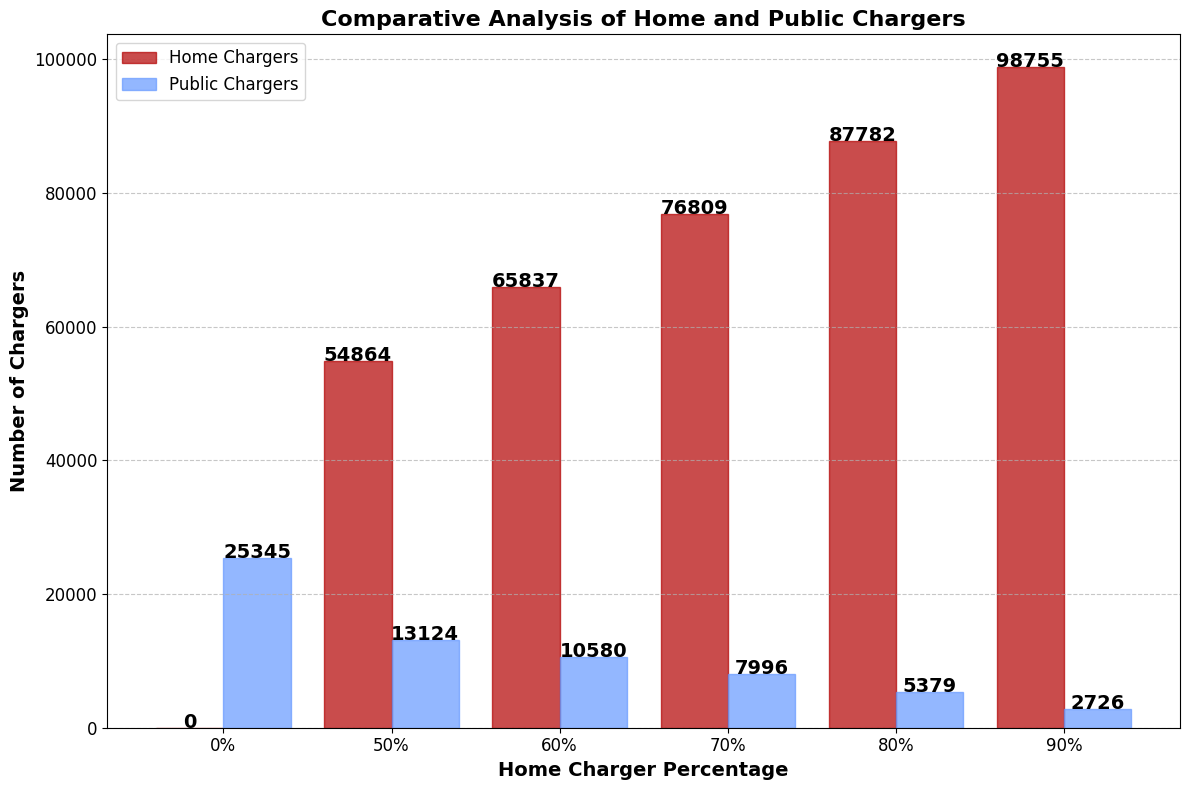

In [4]:
# ---------Stations NEW 
# Step 1: # Number of households with EVs
total_home_chargers = math.ceil(total_ev / 2.02)
print("Total Number of Households with EVs:", total_home_chargers)

# Calculate the minimum SoC required for one EV trip (50%)
required_soc_for_trip = 0.5
charge_threshold = 0.3

# Calculate the average range added per hour for Level 2 and Level 3 chargers
avg_level2_range_added_per_hour = np.mean(level2_range_added_per_hour)
avg_level3_range_added_per_hour = np.mean(level3_range_added_per_hour)

# Define parameters for comparison
home_charger_percentages = [0, 0.5, 0.6, 0.7, 0.8, 0.9]
# Initialize lists to store results
total_public_chargers_list = []
total_home_chargers_list = []

for home_charger_percentage in home_charger_percentages:
    # Set the probability based on home_charger_percentage
    p_home = home_charger_percentage
    p_public = 1 - p_home
    # Initialize SoC for each EV randomly to either 1 or 0.5
    initial_socs = np.random.choice([0.8, required_soc_for_trip], size=len(results_home_charge), p=[p_home, p_public])

    home_charging_count = 0
    public_charging_count_raw = 0
    for index, result in enumerate(results_home_charge):
        departure_times, arrival_times, travel_times = result
        initial_soc = initial_socs[index]
        for i in range(len(travel_times)):
            soc_after_trip = initial_soc - travel_times[i] * 0.004545
            if soc_after_trip >= charge_threshold:
                home_charging_count += 1
                initial_soc = soc_after_trip
            else:
                public_charging_count_raw += 1
                # Charging at public charging stations
                # Randomly select the charger level (82% Level 2, 18% Level 3)
                charger_level = np.random.choice([2, 3], p=[0.82, 0.18])

                if charger_level == 2:
                    range_added_per_hour = np.mean(level2_range_added_per_hour)
                else:
                    range_added_per_hour = np.mean(level3_range_added_per_hour)

                charging_time_to_full = (1 - soc_after_trip) / range_added_per_hour
                charging_time_to_trip = (required_soc_for_trip - soc_after_trip) / range_added_per_hour

                try:
                    next_departure_time = departure_times[i + 1]
                    gap_between_departures = next_departure_time - arrival_times[i]

                    if gap_between_departures >= charging_time_to_full:
                        initial_soc = 1
                    elif gap_between_departures >= charging_time_to_trip:
                        initial_soc = required_soc_for_trip
                    else:
                        initial_soc = soc_after_trip + ((gap_between_departures/60) * range_added_per_hour)

                    if (8 * 60) <= next_departure_time < (9 * 60) or (17 * 60) <= next_departure_time < (18 * 60):
                        if (9 * 60) <= departure_times[i + 1] < (17 * 60) or (18 * 60) <= departure_times[i + 1] or departure_times[i + 1] < (8 * 60):
                            travel_times[i] /= 1.07
                    if (9 * 60) <= next_departure_time < (17 * 60) or (18 * 60) <= next_departure_time or next_departure_time < (8 * 60):
                        if (8 * 60) <= departure_times[i + 1] < (9 * 60) or (17 * 60) <= departure_times[i + 1] < (
                                18 * 60):
                            travel_times[i] *= 1.07

                except:
                    continue
                

    avg_range_added_per_hour = (avg_level2_range_added_per_hour * 0.82) + (avg_level3_range_added_per_hour * 0.18)
    max_charging_time = (205 * (1 / avg_range_added_per_hour)) * (required_soc_for_trip - charge_threshold)  # average time to charge from empty to full
    max_charges_per_station_per_day = 16 / max_charging_time * 4  # 16 hours a day and 4 vehicles at a time

    proportion_households_with_evs = math.ceil((total_ev / total_cars) * total_households)
    total_home_chargers = math.ceil(proportion_households_with_evs * home_charger_percentage)
    public_charging_count = public_charging_count_raw + home_charging_count * (1 - home_charger_percentage)
    total_public_chargers = math.ceil(public_charging_count / max_charges_per_station_per_day)
    total_home_chargers_list.append(total_home_chargers)
    total_public_chargers_list.append(total_public_chargers)
    
    # Print total number of public and home chargers
    print(f"For Home Charger Percentage: {home_charger_percentage * 100}%")
    print(f"Total Number of Public Charging Stations: {total_public_chargers}")
    print(f"Total Number of Home Charging Stations: {total_home_chargers}")
    print()

# Plotting
plt.figure(figsize=(12, 8))
# Plotting columns with custom colors and styles
bar_width = 0.4
index = np.arange(len(home_charger_percentages))
plt.bar(index, total_home_chargers_list, bar_width, label='Home Chargers', color='#b30000', edgecolor='#b30000', alpha=0.7)
plt.bar(index + bar_width, total_public_chargers_list, bar_width, label='Public Chargers', color='#6699ff', edgecolor='#6699ff', alpha=0.7)
# Adding text labels with custom fonts and sizes
for i in range(len(home_charger_percentages)):
    plt.text(index[i], total_home_chargers_list[i] + 10, str(total_home_chargers_list[i]), ha='center', fontsize=14, fontweight='bold')
    plt.text(index[i] + bar_width, total_public_chargers_list[i] + 10, str(total_public_chargers_list[i]), ha='center', fontsize=14, fontweight='bold')

plt.xlabel('Home Charger Percentage', fontsize=14, fontweight='bold')
plt.ylabel('Number of Chargers', fontsize=14, fontweight='bold')
plt.title('Comparative Analysis of Home and Public Chargers', fontsize=16, fontweight='bold')
# Customize x-axis labels to display percentages without decimal points and trailing zeros
plt.xticks(index + bar_width / 2, [f"{int(p*100)}%" for p in home_charger_percentages], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
